In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
sentiment = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment/CSV_files/fear_greed_index.csv')
trader = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Assignment/CSV_files/historical_data.csv")


In [ ]:
print('Trader rows, cols:', trader.shape)
print('Sentiment rows, cols:', sentiment.shape)

Trader rows, cols: (211224, 16)
Sentiment rows, cols: (2644, 4)


In [ ]:
print(sentiment.head())


    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05


In [ ]:
print(trader.head())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

In [ ]:
print(trader.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [ ]:
trader['Timestamp IST'] = pd.to_datetime(trader['Timestamp IST'], format='%d-%m-%Y %H:%M')
sentiment['date'] = pd.to_datetime(sentiment['date'])

In [ ]:
trader['date'] = trader['Timestamp IST'].dt.date
trader['hour'] = trader['Timestamp IST'].dt.hour
trader['weekday'] = trader['Timestamp IST'].dt.weekday

In [ ]:
print(trader[['Timestamp IST','date','hour']].head())

        Timestamp IST        date  hour
0 2024-12-02 22:50:00  2024-12-02    22
1 2024-12-02 22:50:00  2024-12-02    22
2 2024-12-02 22:50:00  2024-12-02    22
3 2024-12-02 22:50:00  2024-12-02    22
4 2024-12-02 22:50:00  2024-12-02    22


In [ ]:
def to_numeric(col):
    return pd.to_numeric(trader[col], errors='coerce')

for col in ['Closed PnL', 'Closed PnL', 'Size Tokens', 'Execution Price']:
    if col in trader.columns:
        trader[col] = to_numeric(col)

In [ ]:
# Convert numeric fields
num_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Start Position', 'Closed PnL', 'Fee']
for col in num_cols:
    trader[col] = pd.to_numeric(trader[col], errors='coerce')




In [ ]:
print(trader[['Execution Price', 'Size Tokens', 'Size USD']].head())

   Execution Price  Size Tokens  Size USD
0           7.9769       986.87   7872.16
1           7.9800        16.00    127.68
2           7.9855       144.09   1150.63
3           7.9874       142.98   1142.04
4           7.9894         8.73     69.75


In [ ]:
# See all unique entries in direction column
trader['Direction'].unique()


array(['Buy', 'Sell', 'Open Long', 'Close Long', 'Spot Dust Conversion',
       'Open Short', 'Close Short', 'Long > Short', 'Short > Long',
       'Auto-Deleveraging', 'Liquidated Isolated Short', 'Settlement'],
      dtype=object)

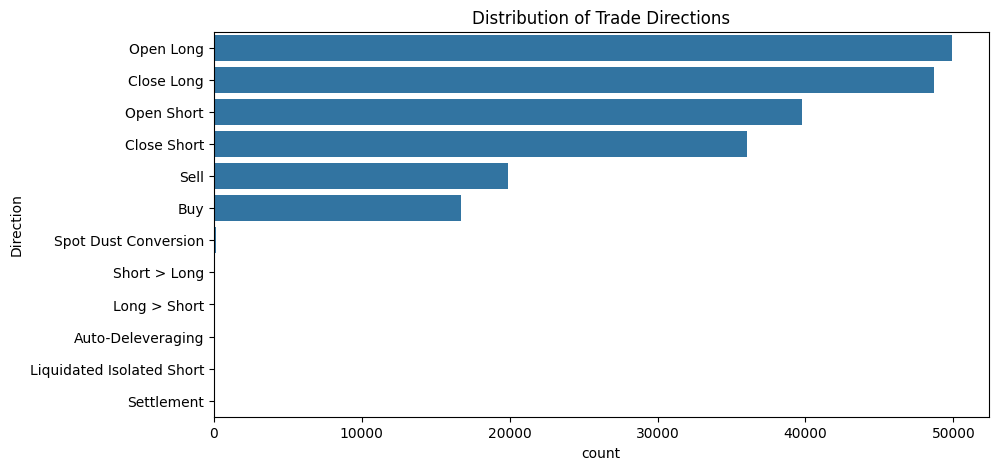

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(y='Direction', data=trader, order=trader['Direction'].value_counts().index)
plt.title('Distribution of Trade Directions')
plt.show()


In [ ]:
# Define keyword lists
open_keywords   = ['Open', 'Buy', 'Sell', 'Open Long', 'Open Short']
close_keywords  = ['Close', 'Close Long', 'Close Short', 'Settlement',]
dust_keywords   = ['dust','Spot Dust Conversion']

def classify_trade(row):
    direction = row['Direction']
    pnl = row['Closed PnL']
    tx = row['Transaction Hash']
    size_usd = row['Size USD']

    # --- Closed Trades ---
    if any(k in direction for k in close_keywords) and pd.notna(pnl):
        return 'Closed'

    # --- Open Trades ---
    if any(k in direction for k in open_keywords) and (pnl == 0 or pd.isna(pnl)):
        return 'Open'

    # --- System Events ---
    if any(k in direction for k in dust_keywords) or str(tx).startswith('0x0') or (size_usd < 1):
        return 'System'

    return 'Other'

# Apply the classification
trader['category'] = trader.apply(classify_trade, axis=1)
trader['category'].value_counts()


,count
category,
Open,106608
Closed,84692
Other,15432
System,4492


In [ ]:
closed_trades  = trader[trader['category'] == 'Closed'].copy()
open_trades    = trader[trader['category'] == 'Open'].copy()
system_events  = trader[trader['category'] == 'System'].copy()

print(f"Closed: {len(closed_trades)} | Open: {len(open_trades)} | System: {len(system_events)}")


Closed: 84692 | Open: 106608 | System: 4492


In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Assignment/CSV_files'
closed_trades.to_csv(save_path + 'closed_trades.csv', index=False)
open_trades.to_csv(save_path + 'open_trades.csv', index=False)
system_events.to_csv(save_path + 'system_events.csv', index=False)


In [ ]:
# Identify numeric columns
numeric_cols = closed_trades.select_dtypes(include=['float64', 'int64']).columns
print("Numeric columns:\n", numeric_cols.tolist())


Numeric columns:
 ['Execution Price', 'Size Tokens', 'Size USD', 'Start Position', 'Closed PnL', 'Order ID', 'Fee', 'Trade ID', 'Timestamp']


In [ ]:
drop_cols = ['order_id', 'trade_id']
closed_trades = closed_trades.drop(columns=[c for c in drop_cols if c in closed_trades.columns], errors='ignore')


In [ ]:
# Detect columns with unrealistically large numbers
large_cols = [c for c in numeric_cols if closed_trades[c].abs().max() > 1e10]
print("Columns with extremely large values:", large_cols)

# Scale them down if they represent timestamps or scaling errors
for col in large_cols:
    closed_trades[col] = closed_trades[col]


Columns with extremely large values: []


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols_to_scale = ['Execution Price', 'Size USD', 'Closed PnL']
closed_trades[cols_to_scale] = scaler.fit_transform(closed_trades[cols_to_scale])

closed_trades.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Order ID,Crossed,Fee,Trade ID,Timestamp,date,hour,weekday,category,trade_date
142,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,AAVE,0.002237,14.78,0.000914,SELL,2024-12-03 20:56:00,1000.00,Close Long,0.466327,...,0.052306,True,1.254400,238.0,1.73,2024-12-03,20,1,Closed,2024-12-03
143,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,AAVE,0.002237,8.65,0.000535,SELL,2024-12-03 20:56:00,985.22,Close Long,0.466098,...,0.052306,True,0.734077,416.0,1.73,2024-12-03,20,1,Closed,2024-12-03
144,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,AAVE,0.002237,13.67,0.000845,SELL,2024-12-03 20:56:00,976.57,Close Long,0.466284,...,0.052306,True,1.160049,1120.0,1.73,2024-12-03,20,1,Closed,2024-12-03
145,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,AAVE,0.002236,0.06,0.000004,SELL,2024-12-03 20:56:00,962.90,Close Long,0.465779,...,0.052306,True,0.005091,59.8,1.73,2024-12-03,20,1,Closed,2024-12-03
146,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,AAVE,0.002236,3.68,0.000227,SELL,2024-12-03 20:56:00,962.84,Close Long,0.465912,...,0.052306,True,0.312159,648.0,1.73,2024-12-03,20,1,Closed,2024-12-03


In [ ]:
sentiment = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment/CSV_files/fear_greed_index.csv')

# Clean column names
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(' ', '_')
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce').dt.date
sentiment.rename(columns={'classification': 'sentiment'}, inplace=True)


In [ ]:
closed_trades['trade_date'] = pd.to_datetime(closed_trades['Timestamp IST'], errors='coerce').dt.date


In [ ]:
merged = pd.merge(
    closed_trades,
    sentiment[['date', 'sentiment']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

print("Merged rows:", len(merged))
print("Unique sentiments:", merged['sentiment'].unique())


Merged rows: 84692
Unique sentiments: ['Extreme Greed' 'Extreme Fear' 'Fear' 'Greed' nan 'Neutral']


Exploratory Data Analysis (EDA)


In [ ]:
merged.groupby('sentiment')['Closed PnL'].mean()


,Closed PnL
sentiment,
Extreme Fear,0.466152
Extreme Greed,0.465959
Fear,0.466275
Greed,0.466049
Neutral,0.466046


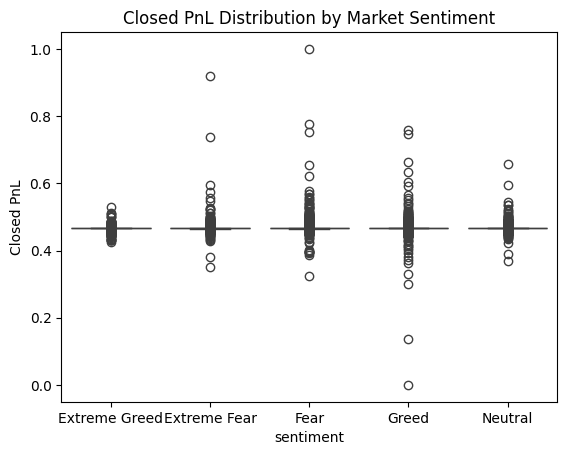

In [ ]:
sns.boxplot(x='sentiment', y='Closed PnL', data=merged)
plt.title('Closed PnL Distribution by Market Sentiment')
plt.show()


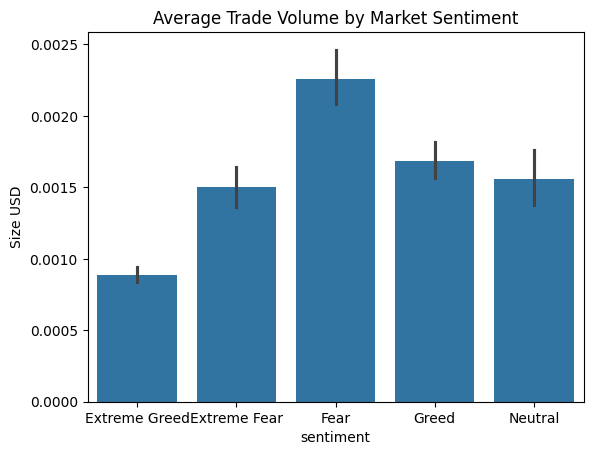

In [ ]:
sns.barplot(x='sentiment', y='Size USD', data=merged, estimator='mean')
plt.title('Average Trade Volume by Market Sentiment')
plt.show()


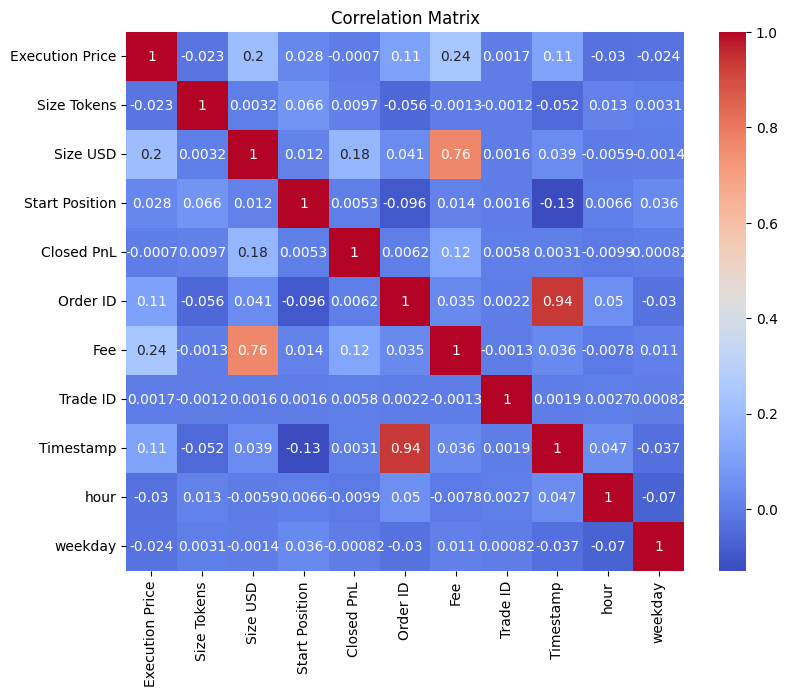

In [ ]:
corr = merged.select_dtypes('number').corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
from scipy.stats import f_oneway

fear = merged[merged['sentiment'] == 'Fear']['Closed PnL']
extreme_fear = merged[merged['sentiment'] == 'Extreme Fear']['Closed PnL']
neutral = merged[merged['sentiment'] == 'Neutral']['Closed PnL']
greed = merged[merged['sentiment'] == 'Greed']['Closed PnL']
extreme_greed = merged[merged['sentiment'] == 'Extreme Greed']['Closed PnL']

f_stat, p_val = f_oneway(fear, extreme_fear, neutral, greed, extreme_greed)
print(f"F-statistic = {f_stat:.4f}, p-value = {p_val:.6f}")

if p_val < 0.05:
    print("✅ Statistically significant difference across sentiment categories.")
else:
    print("⚠️ No statistically significant difference.")


F-statistic = 11.1270, p-value = 0.000000
✅ Statistically significant difference across sentiment categories.


/tmp/ipython-input-1963904566.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-1963904566.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


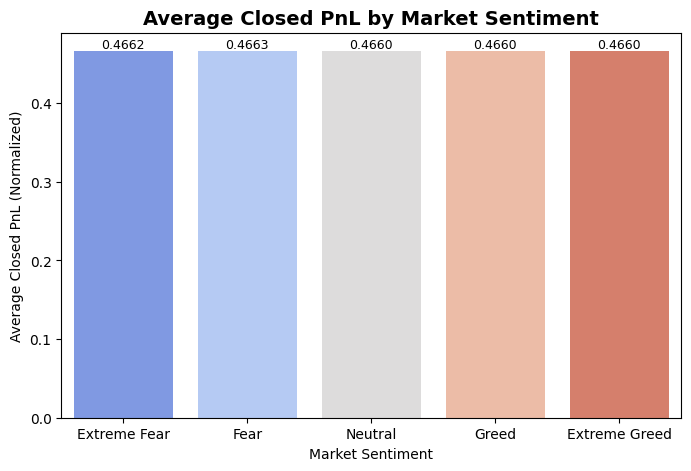

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x='sentiment', y='Closed PnL', data=merged,
    order=['Extreme Fear','Fear','Neutral','Greed','Extreme Greed'],
    ci=None, palette='coolwarm'
)

# Add value labels
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

plt.title('Average Closed PnL by Market Sentiment', fontsize=14, weight='bold')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Closed PnL (Normalized)')
plt.show()


In [ ]:
summary = merged.groupby('sentiment')['Closed PnL'].agg(['mean', 'median', 'std', 'count']).reset_index()
summary = summary.sort_values(by='mean', ascending=False)
summary


,sentiment,mean,median,std,count
2,Fear,0.466275,0.465804,0.005597,26481
0,Extreme Fear,0.466152,0.465808,0.006590,9358
3,Greed,0.466049,0.465792,0.006569,19321
4,Neutral,0.466046,0.465794,0.003060,15843
1,Extreme Greed,0.465959,0.465805,0.001690,13683


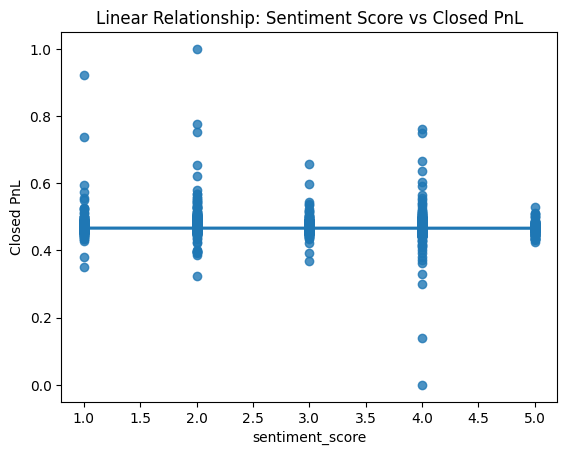

In [ ]:
# Correlation between sentiment score (numeric) and PnL
merged['sentiment_score'] = merged['sentiment'].map({
    'Extreme Fear': 1, 'Fear': 2, 'Neutral': 3, 'Greed': 4, 'Extreme Greed': 5
})

sns.regplot(x='sentiment_score', y='Closed PnL', data=merged)
plt.title("Linear Relationship: Sentiment Score vs Closed PnL")
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Clean column names for consistency
merged.columns = merged.columns.str.lower().str.strip()

# --- Account-level performance summary ---
by_account = merged.groupby('account').agg(
    total_trades=('Timestamp IST', 'count'),                   # total number of trades
    avg_pnl=('Closed PnL', 'mean'),                            # average realized PnL
    total_pnl=('Closed PnL', 'sum'),                           # total profit per trader
    avg_trade_size_usd=('Size USD', 'mean'),                   # average trade size
    median_trade_size_usd=('Size USD', 'median'),              # median trade size
    avg_fee=('Fee', 'mean'),                                   # average fee paid
    win_rate=('Closed PnL', lambda x: (x > 0).mean() * 100),   # % of profitable trades
).reset_index()

# Show top 10 most profitable traders
print("🏆 Top 10 Traders by Average PnL:")
display(by_account.sort_values('avg_pnl', ascending=False).head(10))


KeyError: "Column(s) ['Closed PnL', 'Fee', 'Size USD', 'Timestamp IST'] do not exist"

In [ ]:
# Example: compute simple 'sharpe' = mean_pnl / std_pnl per account
acc_stats = merged.groupby('account')['closedpnl'].agg(['mean','std','count']).reset_index()
acc_stats['sharpe_like'] = acc_stats['mean'] / (acc_stats['std'] + 1e-9)
display(acc_stats.sort_values('sharpe_like', ascending=False).head(10))


In [ ]:
# Choose features and scale
features = by_account[['total_trades','avg_pnl','median_leverage','win_rate']].fillna(0)
scaler = StandardScaler()
X = scaler.fit_transform(features)

# PCA for visualization
pca = PCA(n_components=2)
pc = pca.fit_transform(X)

# Kmeans (choose K by elbow or silhouette; we choose 3 as example)
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
by_account['cluster'] = kmeans.labels_
by_account['pc1'] = pc[:,0]
by_account['pc2'] = pc[:,1]

# Plot clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=by_account, x='pc1', y='pc2', hue='cluster', palette='deep')
plt.title('Trader Clusters (PCA 2D)')
plt.savefig(os.path.join(OUT_DIR,'trader_clusters.png'), bbox_inches='tight')
plt.show()


NameError: name 'by_account' is not defined